In [1]:
import pandas as pd
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

/opt/anaconda3/envs/TestEnv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Preprocssing

In [2]:
# Load dataset
yelp = pd.read_excel('yelp_basic.xlsx')
yelp.head(2)

,Name,links,Rating,Number of reviews,Tag1,Tag2,Tag3,Price,Cleaned_Price,Location,Latest review
0,The Butterfly and the Pig,https://www.yelp.com/biz/the-butterfly-and-the...,4.6,(300 reviews),Scottish,Pubs,Venues & Event Spaces,££,2,City Centre,“The Butterfly and the Pig on Bath Street in G...
1,Ox And Finch,https://www.yelp.com/biz/ox-and-finch-glasgow?...,4.7,(123 reviews),Tapas/Small Plates,Scottish,NaN,££,2,Sauchiehall Street West,"“Upon entering Ox and Finch, you're immediatel..."


In [3]:
# Clean tag
def clean_column(df, column):
    df[column] = df[column].str.replace('&', 'and')
    df[column] = df[column].str.replace('[^a-zA-Z0-9 ]', ' ', regex=True)

clean_column(yelp, 'Tag1')
clean_column(yelp, 'Tag2')
clean_column(yelp, 'Tag3')
clean_column(yelp, 'Name')

# Merge tag
def merge_columns(df, columns, new_column_name):
    def merge_row(row):
        if row.isnull().all():
            return np.nan
        else:
            return ' '.join(row.dropna().values.astype(str))
    
    df[new_column_name] = df[columns].apply(merge_row, axis=1)
    return df

yelp = merge_columns(yelp, ['Tag1', 'Tag2', 'Tag3'], 'cleaned_tag')

# Fill nan in Location column
yelp['Location'] = yelp['Location'].fillna('')

# Turn Number of reviews into numbers
yelp['Number of reviews'] = yelp['Number of reviews'].str.extract('(\d+)').astype(int)

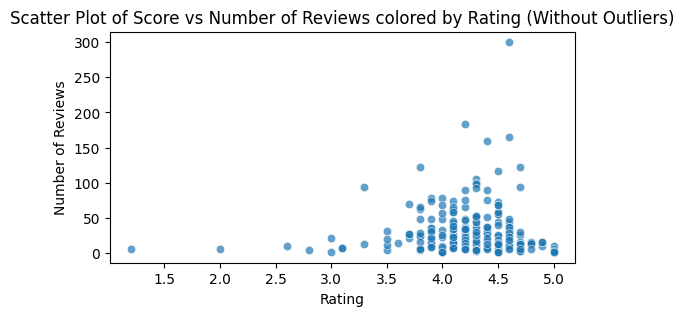

In [4]:
# Explore the data
plt.figure(figsize=(6, 3))
scatter = sns.scatterplot(data=yelp, x='Rating', y='Number of reviews', alpha=0.7)

# Set the title and labels
scatter.set_title('Scatter Plot of Score vs Number of Reviews colored by Rating (Without Outliers)')
scatter.set_xlabel('Rating')
scatter.set_ylabel('Number of Reviews')

# Show the plot
plt.show()

In [5]:
# Number of reviews
def map_reviews_to_score(reviews):
    if reviews < 20:
        return 1
    elif 20 <= reviews <= 40:
        return 2
    elif 40 < reviews <= 60:
        return 3
    else:
        return 4

yelp['review_score'] = yelp['Number of reviews'].apply(map_reviews_to_score)

# Calculate the final score
yelp['Weighted Rating'] = yelp['Rating'] * yelp['review_score']
total_review_score = yelp['review_score'].sum()
yelp['Score'] = yelp['Weighted Rating'] / total_review_score

In [6]:
yelp.head(2)

,Name,links,Rating,Number of reviews,Tag1,Tag2,Tag3,Price,Cleaned_Price,Location,Latest review,cleaned_tag,review_score,Weighted Rating,Score
0,The Butterfly and the Pig,https://www.yelp.com/biz/the-butterfly-and-the...,4.6,300,Scottish,Pubs,Venues and Event Spaces,££,2,City Centre,“The Butterfly and the Pig on Bath Street in G...,Scottish Pubs Venues and Event Spaces,4,18.4,0.041913
1,Ox And Finch,https://www.yelp.com/biz/ox-and-finch-glasgow?...,4.7,123,Tapas Small Plates,Scottish,NaN,££,2,Sauchiehall Street West,"“Upon entering Ox and Finch, you're immediatel...",Tapas Small Plates Scottish,4,18.8,0.042825


In [7]:
yelp.columns

Index(['Name', 'links', 'Rating', 'Number of reviews', 'Tag1', 'Tag2', 'Tag3',
       'Price', 'Cleaned_Price', 'Location', 'Latest review', 'cleaned_tag',
       'review_score', 'Weighted Rating', 'Score'],
      dtype='object')

In [8]:
# Normalized the data
yelp['Score_normalized'] = (yelp['Score'] - yelp['Score'].min()) / (yelp['Score'].max() - yelp['Score'].min())
yelp['Price_normalized'] = (yelp['Cleaned_Price'] - yelp['Cleaned_Price'].min()) / (yelp['Cleaned_Price'].max() - yelp['Cleaned_Price'].min())


In [9]:
yelp = yelp[['Name', 'Score_normalized', 'Rating', 'Number of reviews', 'Price_normalized', 'Location', 'cleaned_tag']]
yelp.head(10)

,Name,Score_normalized,Rating,Number of reviews,Price_normalized,Location,cleaned_tag
0,The Butterfly and the Pig,0.977273,4.6,300,0.50,City Centre,Scottish Pubs Venues and Event Spaces
1,Ox And Finch,1.000000,4.7,123,0.50,Sauchiehall Street West,Tapas Small Plates Scottish
2,Two Fat Ladies at The Buttery,0.698864,4.5,55,0.75,Finnieston,Seafood
3,Sichuan House,0.454545,4.6,38,0.50,Sauchiehall Street,Chinese
4,Ardnamurchan,0.443182,4.5,24,0.00,City Centre,Scottish Wine Bars
5,Stravaigin,0.909091,4.3,105,0.50,West End,Scottish Gastropubs
6,Noodle,0.409091,4.2,37,0.25,City Centre,Dim Sum Noodles
7,The Spanish Butcher,0.204545,4.8,12,0.75,City Centre,Mediterranean Steakhouses Spanish
8,Ubiquitous Chip,0.931818,4.4,160,0.75,Hillhead,Bars Scottish British
9,The Smokin Fox,0.170455,4.2,14,0.50,City Centre,Pubs British


In [10]:
# Load the transformer model and tokenizer
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Set minimum thresholds for Score and Price
MIN_SCORE_THRESHOLD = 0.1
MIN_PRICE_THRESHOLD = 0.1

# Filter out restaurants with low scores or prices
filtered_yelp = yelp[(yelp['Score_normalized'] >= MIN_SCORE_THRESHOLD) & (yelp['Price_normalized'] >= MIN_PRICE_THRESHOLD)]

In [12]:
tag_column = 'cleaned_tag'
additional_columns = ['Score_normalized', 'Price_normalized', 'Location']

# Tokenize and encode each feature separately
def get_embeddings(texts):
    encodings = distilbert_tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    encodings = {key: val.to(device) for key, val in encodings.items()}
    with torch.no_grad():
        outputs = model(**encodings, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1]
        embeddings = torch.mean(hidden_states, dim=1).cpu().numpy()
    return embeddings

# Create embeddings for each feature
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tag_embeddings = get_embeddings(filtered_yelp[tag_column].tolist())
location_embeddings = get_embeddings(filtered_yelp['Location'].tolist())
score_embeddings = get_embeddings(filtered_yelp['Score_normalized'].astype(str).tolist())
price_embeddings = get_embeddings(filtered_yelp['Price_normalized'].astype(str).tolist())

In [13]:
# I consider tag > location > score > price.
def recommend_items(query, num_recommendations=5, weights=None):
    if weights is None:
        weights = {
            'tag': 0.8,
            'location': 0.4,
            'score': 0.2,
            'price': 0.1
        }

    # Generate query embeddings with weights for provided criteria
    query_embeddings_list = []
    combined_weights = 0

    if query.get('tag'):
        query_embeddings_list.append(weights['tag'] * get_embeddings([query['tag']]))
        combined_weights += weights['tag']
    if query.get('Location'):
        query_embeddings_list.append(weights['location'] * get_embeddings([query['Location']]))
        combined_weights += weights['location']
    if query.get('Score_normalized') is not None and query.get('Score_normalized') != '':
        query_embeddings_list.append(weights['score'] * get_embeddings([str(query['Score_normalized'])]))
        combined_weights += weights['score']
    if query.get('Price_normalized') is not None and query.get('Price_normalized') != '':
        query_embeddings_list.append(weights['price'] * get_embeddings([str(query['Price_normalized'])]))
        combined_weights += weights['price']

    if not query_embeddings_list:
        raise ValueError("No valid query parameters provided.")

    query_embeddings = sum(query_embeddings_list) / combined_weights

    # Combine embeddings with weights for the dataset items
    combined_embeddings = (
        weights['tag'] * tag_embeddings +
        weights['location'] * location_embeddings +
        weights['score'] * score_embeddings +
        weights['price'] * price_embeddings
    )

    # Compute the similarity between the query and all items
    query_similarity = cosine_similarity(query_embeddings, combined_embeddings)

    # Get the top N most similar items
    top_indices = np.argsort(-query_similarity[0])[:num_recommendations]
    recommended_items = filtered_yelp.iloc[top_indices]

    # Sort the recommended items by Score_normalized in descending order first, then by other criteria
    recommended_items = recommended_items.sort_values(
        by=['Score_normalized', 'cleaned_tag', 'Location', 'Price_normalized'],
        ascending=[False, True, True, True]  # Ensure Score_normalized is descending
    )

    return recommended_items

In [14]:
### Input the value here
# Price_normalized: from 0 to 1. 0 is cheapest,  1 is expansive.
# Score: This score is calculated by rating and number of reviews. The higher score is better. Score from 0 to 1
query = {
    'Score_normalized':'1' ,
    'Price_normalized': '0.5',
    'Location': '',
    'tag': 'bar'
}

recommended_items = recommend_items(query, num_recommendations=5)
recommended_items

,Name,Score_normalized,Rating,Number of reviews,Price_normalized,Location,cleaned_tag
100,Halloumi,0.409091,4.2,22,0.50,City Centre,Greek Bars
233,Max s Bar and Grill,0.397727,4.1,39,0.50,City Centre,American Bars
221,Smoak BBQ,0.329545,3.5,20,0.50,City Centre,Barbeque
179,La Bodega Tapas Bar,0.187500,4.5,6,0.25,,Tapas Bars Music Venues
207,El Gusto,0.147727,3.8,4,0.25,West End,Tapas Bars
